# Libraries

In [70]:
import numpy as np
def vol_flow_delta(T,N):
    v=np.random.normal(0,1,(N,T))
    return v

import pandas as pd
from scipy.linalg import eigh, cholesky
from scipy.stats import norm
import scipy.linalg as linalg 
from scipy.linalg import eigh, cholesky

def vol_flow_exp(frequency, T, n):
    frequency = frequency
    T = T
    n = n
    gauss= VolFlow(T,n)
    corr = (np.fromfunction(lambda i, j: np.exp(-frequency*np.absolute(i-j)), (T, T), dtype=float))
    C = corr
        
    chol = cholesky(C, lower=True)
    order_flow =  chol @ gauss.transpose()
    return order_flow

In [71]:
import matplotlib.pyplot as plt

def correlation(x, y, taus):
    """Inputs :
    x: pd.Series
    y: pd.Series
    taus: array of integers
    Returns:
    A numpy array containing the correlation function as the average x(t)*y(t+tau)
    for each value of tau in taus"""
    def c_group(T):
        return (x*y.shift(-T)).mean()
    c_g = np.vectorize(c_group)
    return c_g(taus)

def delta(x):
    if x ==0:
        return 1;
    else: 
        return 0;
    
def variogram(x, taus):
    """Inputs:
    x: pd.Series
    taus: array of integers
    Returns:
    A numpy array containing the variogram of x evaluated at each value of tau in taus"""
    def vgram(T):
        return (x - x.shift(T)).var()
    vgram = np.vectorize(vgram)
    return vgram(taus)

In [168]:
def Mforecast(tipo, process, param,i,T):
        M = []
        C_NT_0 = 1
        t0 = i
        tau_mu = param[0]
        tau_NT = param[1]
        
        if tipo == "mark":
            if process == "MU":
                alpha_appo = np.exp(-1/param[0])
                C_appo = np.fromfunction(lambda i,j : alpha_appo**np.abs(i-j), (T,T), dtype = float)
            if process == "NT":
                if tau_NT == 0:
                    C_appo = np.fromfunction(lambda i,j : np.vectorize(delta)(i-j), (T,T), dtype = np.float)
                else:
                    alpha_appo = np.exp(-1/param[1])
                    C_appo = np.fromfunction(lambda i,j : alpha_appo**np.abs(i-j), (T,T), dtype = float)
        
        g = np.zeros((T-t0,t0))
        for I in range (t0,t0+1):
            for J in range (I+1,T+1):
                C = C_appo[:J,:J]
                current = I
                inv_C = np.linalg.inv(C)
                inv_C_int = inv_C[I:J-1,I:J-1]
                #print(inv_C_int)
                inv_inv_C_int = np.linalg.inv(inv_C_int)
                delta_inv_C = +inv_C[:,I:J-1].dot(inv_inv_C_int).dot(inv_C[I:J-1,:])
                matrix = (inv_C[J-1,J-1]-delta_inv_C[J-1,J-1])**(-1)*(inv_C-delta_inv_C)
                M.append(matrix)
                g[J-t0-1,:t0] = M[0][J-1,:t0]
                M = []
            M = []
        return g

def return_Mfcast_mu_g(T,M1):
    e1 = np.asarray(np.zeros(T))
    e1[0] = 1
    Mfcast_mu_g = np.zeros((T,T))
    Mfcast_mu_g[0] = e1
    Mfcast_mu_g[1:,:] = M1[:T-1,:T]
    return Mfcast_mu_g


def return_SumC_mu_final(T,M2):
    SumC_mu_final = np.zeros((T,T))
    for i in range (0,T):
        for j in range (0,T):
            if j==0:
                SumC_mu_final[i,j] = np.sum(M2[i,:])
            if j==1:
                SumC_mu_final[i,j] = np.sum(M2[i,:])-M2[i,0]
            if j>1:
                SumC_mu_final[i,j]  = np.sum(M2[i,:])-np.sum(M2[:,:j][i,:])
    return SumC_mu_final


def return_G_seed(T,p):
    G_0_seed = 1
    alpha_G = np.exp(-1/p[0])
    G_seed = G_0_seed*np.fromfunction(lambda i,j : alpha_G**np.abs(i-j)*np.heaviside(j-i,1), (T,T),dtype = np.float)
    return G_seed


def return_st_M(T,m):
    M = np.zeros((T,T))
    for i in range (0,T):
        M[i,i:T] = m[0:T-i]
    return M


def return_futpast(T,M):
    Gfutpast = np.zeros((T,T),dtype = np.float)
    for i in range (0,T):
        Gfutpast[i,:T-i-1] = M[0,i+1:T]
    return Gfutpast

In [159]:
def SCI_Numerical_solver_myopic_MARKOV(T,T_it,alpha_mu,alpha_NT, C_mu_0,C_NT_0,G_S):
    
    critical = []
    
    
    if G_S == []:
        G_0_seed = np.float128(1-(1-np.sqrt(1-alpha_mu**2))/alpha_mu**2)
        alpha_G = np.float128(alpha_mu)
        G_seed = G_0_seed*np.fromfunction(lambda i,j : alpha_mu**np.abs(i-j)*np.heaviside(j-i,1), (T,T),dtype = np.float128)
            
    else: 
        G_seed = G_S    
    G = G_seed
    G_record = np.zeros((T_it+1,T),dtype = np.float128)
    G_record[0] = G[0]
    
    C_mu = C_mu_0* np.fromfunction(lambda i,j : alpha_mu**np.abs(i-j), (T,T), dtype = np.float128)
    
    
    if alpha_NT == 0:
        C_NT = C_NT_0* np.fromfunction(lambda i,j : np.vectorize(delta)(i-j), (T,T), dtype = np.float128)
    else:
        C_NT = C_NT_0* np.fromfunction(lambda i,j : alpha_NT**np.abs(i-j), (T,T), dtype = np.float128)
    
    L = np.fromfunction(lambda i, j: np.vectorize(delta)(i-j+1), (T,T), dtype = np.float128)

    SumC_mu  = np.zeros(T, dtype = np.float128)
    for i in range (0,T):
            if i==0:
                SumC_mu[i] = np.sum(C_mu[0,:])
            if i==1:
                SumC_mu[i] = np.sum(C_mu[0,:])-C_mu[0,0]
            if i>1:
                SumC_mu[i]  = np.sum(C_mu[0,:])-np.sum(C_mu[:i,:i][0,:])
    SumC_mu = SumC_mu/C_mu_0
    
    plt.plot(G_seed[0], label = 'seed')
    for j in range(0,T_it):
        Inv_G_sym = linalg.inv(G+np.transpose(G))
        k_mu = alpha_mu * Inv_G_sym.dot(SumC_mu)[0]
        K_mu = k_mu *L
        k0 = -Inv_G_sym[0,:].dot(np.transpose(G)).dot(C_NT[:,0])*alpha_NT/C_NT_0
        K_0 = k0 *L
        
        #print('K_mu',K_mu)
        
        Gfutpast = np.zeros((T,T),dtype = np.float128)
        
        for i in range (0,T):
            Gfutpast[i,:T-i-1] = G[0,i+1:T]  
        k = -(Inv_G_sym.dot(Gfutpast))[0]
        K = np.zeros((T,T),dtype = np.float128)
        for i in range (0,T):
            K[i,i+1:T] = k[:T-i-1]
        
        #print('K',K)
        Sigma = (np.identity(T)+K_0).dot(C_NT).dot(np.transpose(np.identity(T)+K_0))
        g = (linalg.inv(linalg.inv(C_mu)+np.transpose(K_mu).dot(linalg.inv(Sigma)).dot(K_mu)).dot(np.transpose(K_mu)).dot(linalg.inv(Sigma)).dot(np.identity(T)-K)/(1-alpha_mu))[0]
        #print('FIlter',g)
        
        G_record[j+1,:] = np.abs(g)
        
        G_final = np.zeros((T,T) ,dtype = np.float128)
        for i in range (0,T):
            G_final[i,i:T] = g[0:T-i] 
        G = G_final
        G_S = G
    
    plt.plot(G[0],label = 'fixed point')
    plt.legend()
    plt.show()
        
        
        
        
    C_TOT = linalg.inv(np.identity(T)-K).dot(Sigma+K_mu.dot(C_mu).dot(np.transpose(K_mu))).dot(np.transpose(linalg.inv(np.identity(T)-K)))
    plt.plot(C_TOT[0],label = 'C_Q')
    plt.legend()
    plt.show()
    C_p = G.dot(C_TOT).dot(np.transpose(G))
    
    D_NT = linalg.inv(np.identity(T)-K).dot(np.identity(T)+K_0)
    D_IT_NT = linalg.inv(np.identity(T)-K).dot(K+K_0)
    D_mu = linalg.inv(np.identity(T)-K).dot(K_mu)
              
    return  G,D_NT,D_mu, C_p, C_TOT,D_IT_NT, SumC_mu


In [524]:
def Numerical_solver_myopic_GENERAL(T,T_it,tipo, param_ampli,param):
    
    L = np.fromfunction(lambda i, j: np.vectorize(delta)(i-j+1), (T,T), dtype = np.float)
    G_seed = return_G_seed(T,param)
    G = G_seed
    
    
    G_record = np.zeros((T_it+1,T),dtype = np.float)
    G_record[0] = G[0]
    
    
    C_mu_0 = param_ampli[0]
    C_NT_0 = param_ampli[1]
    
    if tipo == "mark":
        tau_mu = param[0]
        tau_NT = param[1]
        alpha_mu = np.exp(-1/param[0])
       
        C_mu = C_mu_0* np.fromfunction(lambda i,j : alpha_mu**np.abs(i-j), (T,T), dtype = np.float)
        if tau_NT == 0:
            C_NT = C_NT_0* np.fromfunction(lambda i,j : np.vectorize(delta)(i-j), (T,T), dtype = np.float)
        else:
            alpha_NT = np.exp(-1/param[1])
            C_NT = C_NT_0* np.fromfunction(lambda i,j : alpha_NT**np.abs(i-j), (T,T), dtype = np.float)
    
    
    Mfcast_mu = -np.transpose(np.flip(Mforecast(tipo,"MU",param,T,2*T),1))
    Mfcast_nt = -np.flip(Mforecast(tipo, "NT",param,T,2*T),1).dot(L)
    #print('fcastNT',np.flip(Mforecast(tipo, "NT",param,T,2*T),1).dot(L))
    
    appo = np.transpose(Mfcast_mu)
    Mfcast_mu_g = return_Mfcast_mu_g(T,appo)
    SumC_mu_final = return_SumC_mu_final(T,Mfcast_mu)
    
    ##print('SumC_mu_final',SumC_mu_final)
    for j in range(0,T_it):
        Inv_G_sym = np.linalg.inv(G+np.transpose(G))
        
        ##print('INV_G_SYM',Inv_G_sym)
        k_mu = Inv_G_sym.dot(np.transpose(SumC_mu_final))[0].dot(L)
        K_mu = return_st_M(T,k_mu)
        
        ##print('K_mu',K_mu)
        k0 = -Inv_G_sym[0,:].dot(np.transpose(G)).dot(Mfcast_nt)
        K_0 = return_st_M(T,k0)
        
    
        Gfutpast = return_futpast(T,G)
        
        k = -(Inv_G_sym.dot(Gfutpast))[0]
        K = return_st_M(T,k).dot(L)
        
        
        #print('K_mu',K_mu)
        #print('K',K)
        #print('K_0',K_0)
        #print('C_mu',C_mu)
        #print('C_NT',C_NT)
        
        
        Sigma = (np.identity(T)+K_0).dot(C_NT).dot(np.transpose(np.identity(T)+K_0))
        
        #print('Sigma',Sigma)
        ##print((np.linalg.inv(np.linalg.inv(C_mu)+np.transpose(K_mu).dot(np.linalg.inv(Sigma)).dot(K_mu))).dot(np.transpose(K_mu)))
        Filter_mu = (np.linalg.inv(np.linalg.inv(C_mu)+np.transpose(K_mu).dot(np.linalg.inv(Sigma)).dot(K_mu)).dot(np.transpose(K_mu)).dot(np.linalg.inv(Sigma)).dot(np.identity(T)-K))
        
        #print('Sigma',Sigma)
        #print('Filter_mu',Filter_mu)
        g_final  = Mfcast_mu_g.dot(Filter_mu)#*C_mu_0/(1-alpha_mu)
        #print('Mfcast_mu_g',Mfcast_mu_g)
        #print('g_final',g_final)
        
        appo = np.sum(g_final,axis = 0)
        g = appo
        
        #print('g',g)
        ##print('R',K)
        ##print('K_mu',K_mu)
        ##print('K_0',K_0)
        ##print('Sigma',Sigma)
        ##print('Filter_mu',Filter_mu)
        
        #G_record[j+1,:] = g
    
        G_final = return_st_M(T,g)
        
        G = G_final
        
    
    C_IT = np.linalg.inv(np.identity(T)-K).dot((K+K_0).dot(C_NT).dot(np.transpose(K+K_0))+K_mu.dot(C_mu).dot(np.transpose(K_mu))).dot(np.transpose(np.linalg.inv(np.identity(T)-K)))
        
    C_TOT = linalg.inv(np.identity(T)-K).dot((np.identity(T)+K_0).dot(C_NT).dot(np.transpose(np.identity(T)+K_0))+K_mu.dot(C_mu).dot(np.transpose(K_mu))).dot(np.transpose(np.linalg.inv(np.identity(T)-K)))
    
    inv_C_tot = np.linalg.inv(C_TOT)
    C_p = G.dot(C_TOT).dot(np.transpose(G))
    C_p_IT = np.transpose(SumC_mu_final).dot(L).dot(C_mu).dot(np.transpose(L)).dot(SumC_mu_final)
    C_p_best = np.transpose(SumC_mu_final).dot(C_mu).dot(SumC_mu_final)
    
    D_NT = linalg.inv(np.identity(T)-K).dot(np.identity(T)+K_0)
    D_IT_NT = linalg.inv(np.identity(T)-K).dot(K+K_0)
    D_mu = linalg.inv(np.identity(T)-K).dot(K_mu)
    
    return G,D_NT,D_mu, C_p, C_TOT,D_IT_NT, SumC_mu_final
    


In [ ]:
def Compute_corr(df,T_corr,n):
    Corr = np.zeros(T_corr)
    for i in range(0,n):
        Corr+= correlation(df[i],df[i],np.arange(0,T_corr))/n
    return Corr

In [ ]:
def Compute_xcorr(df1,df2,T_corr,n):
    Corr = np.zeros(T_corr)
    for i in range(0,n):
        Corr+= correlation(df1[i],df2[i],np.arange(0,T_corr))/n
    return Corr

# Params 

In [543]:
n = 2000
T = 300
T_corr = 100

tipo = 'mark'
tau_mu = 5
frequency_mu = 1/tau_mu
alpha_mu = np.exp(-1/tau_mu)
tau_NT = 3
if tau_NT == 0:
    alpha_NT = 0
else:
    alpha_NT = np.exp(-1/tau_NT)
C_mu_0 = ((1-alpha_mu)/alpha_mu)**2
C_NT_0 = 1
param = [tau_mu,tau_NT]
param_ampli = [C_mu_0,C_NT_0]

In [544]:
T_it = 100
G,D_NT,D_mu,C_p,C_tot,D_IT_NT,SumC_mu =  Numerical_solver_myopic_GENERAL(T+1,T_it,tipo, param_ampli,param)

In [546]:
mu_flow = np.sqrt(C_mu_0)*pd.DataFrame(vol_flow_exp(frequency_mu,T+1,n))
if tau_NT == 0:
    NT_flow = np.sqrt(C_NT_0)*pd.DataFrame(vol_flow_delta(T+1,n)).transpose()
else:
    NT_flow = np.sqrt(C_NT_0)*pd.DataFrame(vol_flow_exp(1/tau_NT,T+1,n))
TOT_flow = pd.DataFrame(D_NT.dot(NT_flow)+ D_mu.dot(mu_flow) )
IT_flow = pd.DataFrame(D_IT_NT.dot(NT_flow)+ D_mu.dot(mu_flow) )
P_flow = pd.DataFrame(G.dot(TOT_flow))

In [547]:
p_F_flow = (SumC_mu.transpose()[0][0]*mu_flow).shift(-1).dropna()
p_F_flow = p_F_flow.reset_index()
p_F_flow = p_F_flow.drop(columns = 'index')

In [548]:
TOT_flow = TOT_flow[:-1].reset_index().drop(columns = 'index')
IT_flow = IT_flow[:-1].reset_index().drop(columns = 'index')
NT_flow = NT_flow[:-1].reset_index().drop(columns = 'index')
P_flow = P_flow[:-1].reset_index().drop(columns = 'index')

%% latex

tracking price

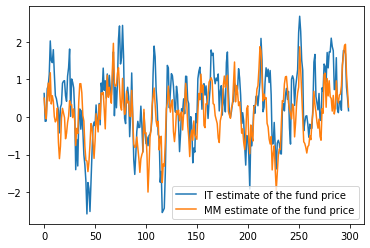

In [549]:
p_F_flow[10].plot(label = 'IT estimate of the fund price')
P_flow[10].plot(label = 'MM estimate of the fund price')
plt.legend()
plt.show()

In [550]:
S_flow = P_flow-p_F_flow

%%latex

Check that $\langle p_t(p^F_t-p_t) \rangle = 0$

In [551]:
cross = S_flow*P_flow
avg_cross = 0
for i in range(0,n):
    avg_cross += cross[i][:-100].mean()/n
avg_cross

0.0005381940814277621

%% latex

Check that $\langle C^F_{t-t'}\rangle  = \langle C^p_{t-t'} + C^{err}_{t-t'}+C^{mix,1}_{t-t'}+C^{mix,2}_{t-t'}\rangle$

In [552]:
appox = Compute_xcorr(P_flow[:-100],-S_flow[:-100],T_corr,n)
appomenox = Compute_xcorr(-S_flow[:-100],P_flow[:-100],T_corr,n)
appoP = Compute_corr(P_flow[:-100],T_corr,n)
appoS = Compute_corr(S_flow[:-100],T_corr,n)

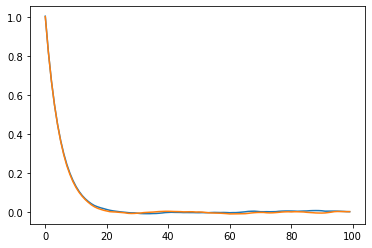

In [535]:
plt.plot(appoP+appoS+appox+appomenox)
plt.plot(C_mu/C_mu[0])

%% latex

Check the gain of the different players, in particular in this case (Markovian with white noise) I know that

$gain_{NT} = -\langle q^{NT}_t(p_t-p^F_t) \rangle = -G_0$

In [536]:
cash_MM_flow = TOT_flow*S_flow
cash_IT_flow = -IT_flow*S_flow
cash_NT_flow = -NT_flow*S_flow

In [541]:
avg_cash_MM = 0
avg_cash_IT = 0
avg_cash_NT = 0
for i in range(0,n):
    avg_cash_MM += cash_MM_flow[i][:-100].mean()/n
    avg_cash_IT += cash_IT_flow[i][:-100].mean()/n
    avg_cash_NT += cash_NT_flow[i][:-100].mean()/n
print(' avg_cash_MM',avg_cash_MM,'\n avg_cash_IT',avg_cash_IT,'\n avg_cash_NT',avg_cash_NT,'\n G_0',G[0,0])

 avg_cash_MM -0.0018548648894398253 
 avg_cash_IT 0.36708716247611856 
 avg_cash_NT -0.36523229758667886 
 G_0 0.36474767574652306
